<a href="https://colab.research.google.com/github/yunariver/newproject/blob/main/Predicting_Stock_Prices_with_PyTorch_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univalent 시계열 예측 -> 종가 기준.

[링크 텍스트](https://)https://aboutnlp.tistory.com/55

In [1]:
pip install finance-datareader

## Load Data

In [2]:
import FinanceDataReader as fdr
fdr.__version__

'0.9.66'

In [8]:

'''
# KOSPI Index 코스피 지수 데이터
df = fdr.DataReader('KS11', '2020') # 2020-01-01 ~ 현재
df = fdr.DataReader('KS11', '2022-01-01', '2022-12-31') # 2022-01-01 ~ 2022-12-31
'''

(246,)

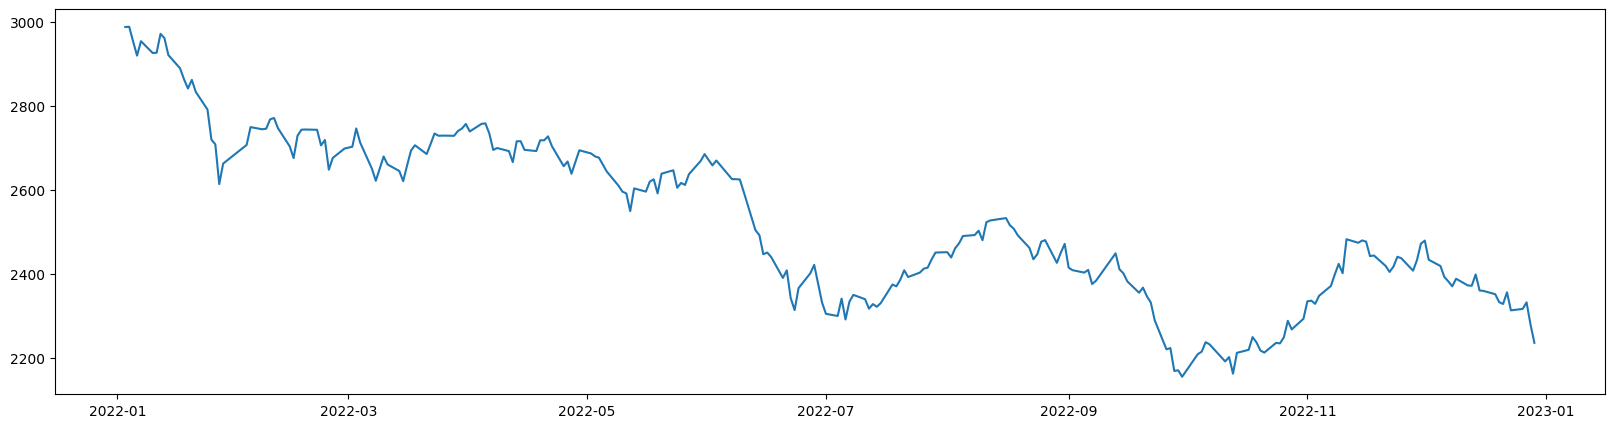

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = fdr.DataReader('KS11', '2022-01-01', '2022-12-31')
plt.figure(figsize=(20,5))
plt.plot(df['Close'])
df['Close'].shape

sklearn의 MinMaxSclaer를 사용하여 데이터의 범위를 0~1로 변환시킴

In [63]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1,1))
df['Close'].head()

Date
2022-01-03    0.999436
2022-01-04    1.000000
2022-01-05    0.957697
2022-01-06    0.917589
2022-01-07    0.958801
Name: Close, dtype: float64

마지막 한달을 기준으로 train, test set을 나눠주었다

In [64]:
train = df[:-30]
data_train = train['Close'].to_numpy()

test = df[-30:]
data_test = test['Close'].to_numpy()

## Transformer Encoder, Transformer Decoder

window dataset을 생성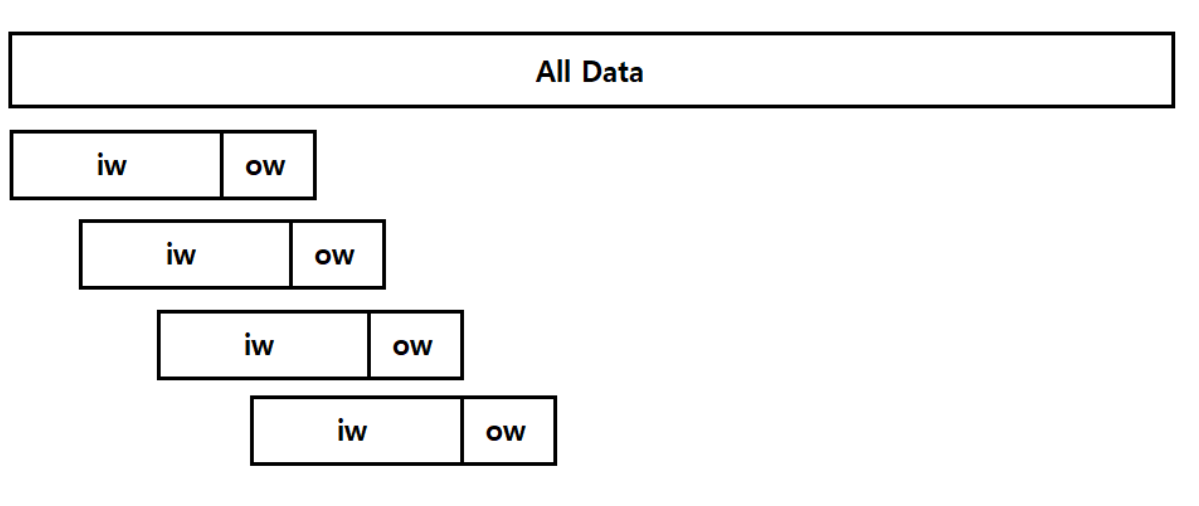

In [65]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y

        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

input window, output window, stride를 입력받고 iw+ow만큼의 길이를 stride간격으로 sliding하면서 데이터셋을 생성한다.

transformer의 input, decoder intput, output으로 활용하기 위해 세 가지의 값을 return하도록 만들었다.

첫 번째 값으로는 input window, 두 번째 값으로는 output window에서 마지막 값을 제외한 값, 마지막 값으로는 output window에서 첫 번째 값을 제외한 값을 return하도록 했다.

아웃풋 윈도우는 예측길이인 30일, 인풋윈도우는 그의 두배인 60일,.

In [66]:
iw = 60
ow = 30

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

## Modeling

In [67]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask



데이터가 univariate time series이므로 input과 output의 차원은 모두 1차원이다.

인풋 데이터인 1차원의 벡터를 d_model의 차원으로 linear layer를 통해 바꿔준 후 positional encoding을 거쳐서 transformer를 통과하게 만들었다. 결과의 차원을 다시 1차원으로 만들어서 최종 output이 나오도록 했다.

자연어 처리때와는 달리 패딩없이 모든 데이터가 값을 가지고 있으므로 padding mask는 생략했다.

## Training


In [68]:
device = torch.device("cuda")

lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [69]:
epoch = 2000
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0

    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))

        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.00098: 100%|██████████| 2000/2000 [01:48<00:00, 18.46it/s]


## Evaluate

In [25]:
def evaluate(length):
    input = torch.tensor(data_train[-60:]).reshape(1,-1,1).to(device).float().to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

인풋 데이터로 train data의 마지막 30일의 데이터를 사용하고, 디코더의 인풋으로는 train data의 마지막 값을 사용했다.

다음 값을 예측하는 과정을 예측할 길이만큼 반복하면서 output을 update했다.

원하는 길이 만큼 예측을 완료하면 최종값을 return한다.

In [32]:
result = evaluate(30)
result = min_max_scaler.inverse_transform(result)
real = df['Close'].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

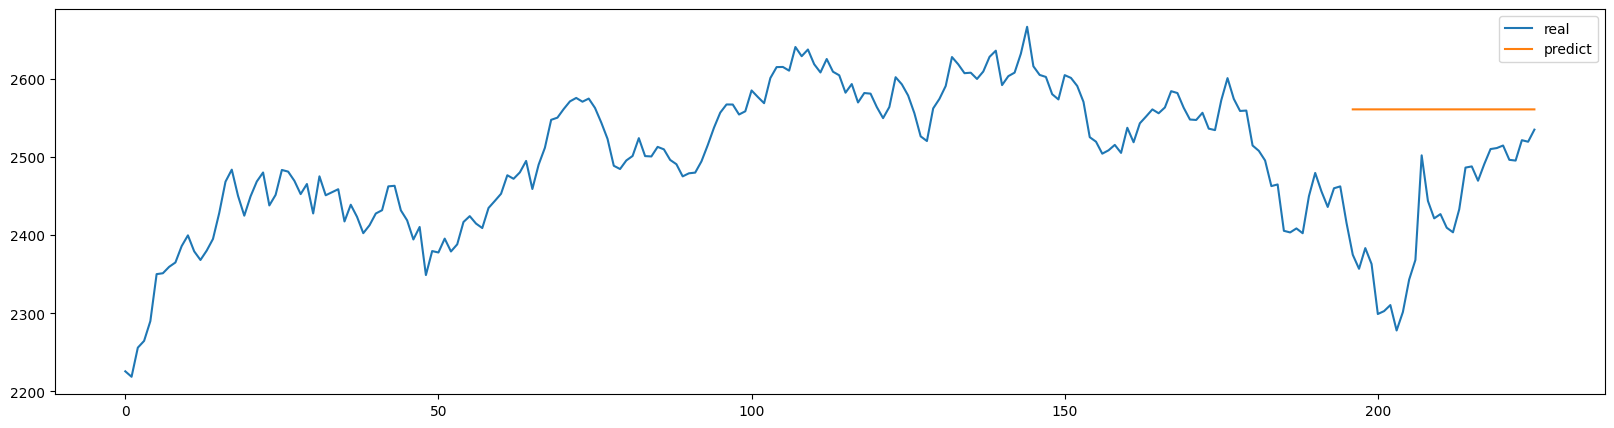

In [34]:
plt.figure(figsize=(20,5))
plt.plot(range(226),real[:226], label="real") #226개의 데이
plt.plot(range(226-30,226),result, label="predict")

plt.legend()
plt.show()

전혀 예측을 하지 못함
24*7이라는 많은 step의 예측을 반복적으로 디코더에서 한개의 값씩 결과를 예측할 만큼 충분한 정보를 학습하지 못하는 것이라고 생각된다.



결과를 개선하기 위해 decoder에서 결과를 반복적으로 1step씩 예측하는게 아니라 FC layer를 통해 한번에 예측하는 모델로 다시 모델링을 진행해 보았다

## Transformer Encoder, FC layer Decoder

## Dataset

In [45]:

from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y

        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [49]:
iw = 60
ow = 30

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

첫번째 값에서는 input window크기의 input data, 두번째 값에서는 output window 크기의 output data를 return한다.

## Modeling
transformer decoder를 사용하지 않고 transformer encoder의 output에 FC Layer를 연결해서 결과를 바로 예측한다

In [50]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, d_model)
        )

        self.linear =  nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw+ow)//2),
            nn.ReLU(),
            nn.Linear((iw+ow)//2, ow)
        )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0,1), srcmask).transpose(0,1)
        output = self.linear(output)[:,:,0]
        output = self.linear2(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

다음과 같은 순서로 진행되도록 모델링 했다.

- 1차원 벡터를 d_model 차원으로 바꿔준다.
(batch, input_window, 1) => (batch, input_window, d_model)

- transformer encoder를 통과한다.
(batch, input_window, d_model) => (batch, input_window, d_model)
- 결과의 d_model차원을 1차원으로 바꿔준다.
(batch, input_window, d_model) => (batch, input_window, 1)
- 1차원인 부분을 없앤다.
(batch, input_window, 1) => (batch, input_window)
- input_window차원을 output_window차원으로 바꿔준다.
(batch, input_window) => (batch, output_window)
- input window의 attention의 조합으로 output window를 바로 예측할 수 있다는 가정으로 모델을 만들었다.

linear layer들은 두 개씩 쌓아줬다

## Training

In [51]:
device = torch.device("cuda")
lr = 1e-4
model = TFModel(60, 30, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [52]:
epoch = 1000
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device),  src_mask)
        loss = criterion(result, outputs[:,:,0].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_loader)))

loss: 0.001612: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


## Evaluate

In [53]:
def evaluate():
    input = torch.tensor(data_train[-60:]).reshape(1,-1,1).to(device).float().to(device)
    model.eval()

    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

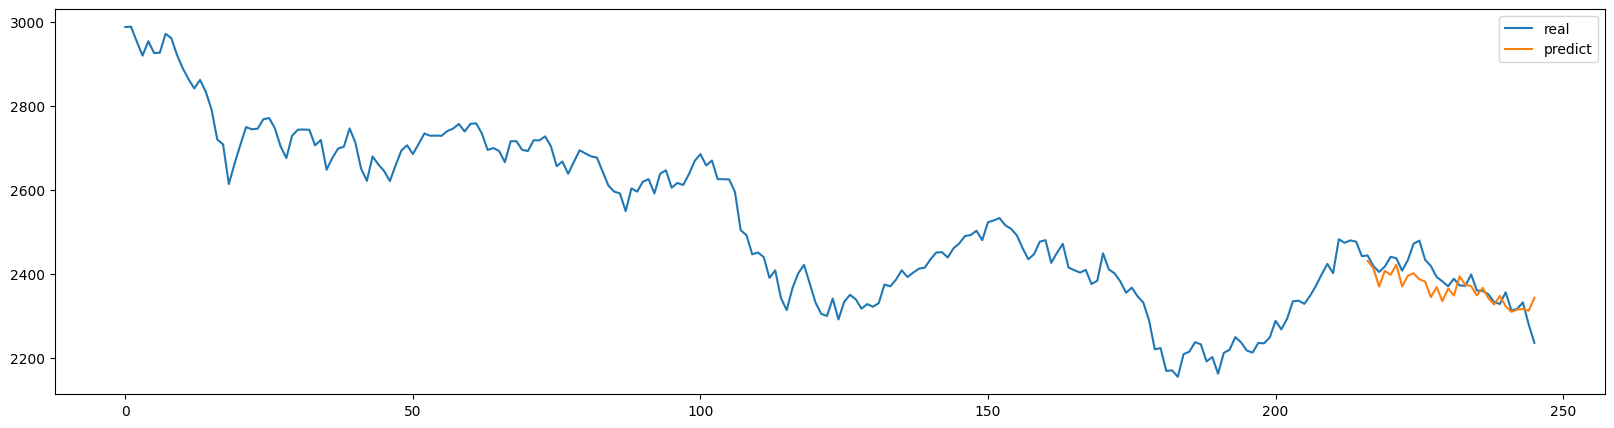

In [54]:
result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = df['Close'].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1,1))[:,0]


plt.figure(figsize=(20,5))
plt.plot(range(246),real[:246], label="real")
plt.plot(range(246-30,246),result, label="predict")
plt.legend()
plt.show()

In [56]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPEval(result, real[-30:])

1.2563405971834027